In [3]:
%pip install torch --index-url https://download.pytorch.org/whl/cu130

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu130
  Using cached https://download.pytorch.org/whl/cu130/torch-2.9.1%2Bcu130-cp313-cp313-win_amd64.whl.metadata (29 kB)
  Using cached https://download.pytorch.org/whl/sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached https://download.pytorch.org/whl/networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached https://download.pytorch.org/whl/mpmath-1.3.0-py3-none-any.whl (536 kB)
   ---------------------------------------- 0.0/1.9 GB ? eta -:--:--
   ---------------------------------------- 0.0/1.9 GB ? eta -:--:--
   ---------------------------------------- 0.0/1.9 GB 4.0 MB/s eta 0:07:41
   ---------------------------------------- 0.0/1.9 GB 3.8 MB/s eta 0:08:09
   ---------------------------------------- 0.0/1.9 GB 3.5 MB/s eta 0:08:54
   ---------------------------------------- 0.0/1.9 GB 3.6 MB/s eta 0:08:41
   -----------------------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\joanc\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [13]:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.0-cp313-cp313-win_amd64.whl.metadata (115 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------- -------------------------------- 1.6/8.1 MB 9.8 MB/s eta 0:00:01
   ---------------- ----------------------- 3.4/8.1 MB 8.9 MB/s eta 0:00:01
   ------------------------- -------------- 5.2/8.1 MB 8.8 MB/s eta 0:00:01
   ------------------------------------ --- 7.3/8.1 MB 9.0 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\joanc\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
# Importar dependencias
import xgboost as xgb
import numpy as np
import shutil
import glob
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight

import sys
import os

sys.path.append(os.path.abspath('..'))
from src.v2.data_loader import data_generator
from src.v2.maps import OTHER_LABEL

C:\Users\joanc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
# Paths de los archivos
csv_file = "../data/processed/dataset_reducido_30p.csv"
model_output = "../models/modeloxgb_vulnerabilidades.json"

In [52]:
val_dir = "../data/temp_validation"

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

In [ ]:
# Función principal de entrenamiento incremental
def train_incremental():

    # Parámetros de XGBoost
    params = {
        ## Probabilidades multiclase
        'objective': 'multi:softprob',
        ## Número de clases (0=Safe, 1..N=Top CWEs, N+1=Other)  
        'num_class': OTHER_LABEL + 1,
        ## Profundidad máxima de cada árbol
        'max_depth': 10,
        ## Tasa de aprendizaje (eta) 
        'learning_rate': 0.1,
        ## Método de construcción de árboles (hist: basado en histogramas)
        'tree_method': 'hist',
        ## Uso de GPU para entrenamiento
        'device': 'cuda',
        ## Métrica de evaluación (logaritmo de pérdida para clasificación multiclase)
        'eval_metric': 'mlogloss',
        ## Uso de todos los núcleos posibles
        'n_jobs': -1,
        ## Muestreo de columnas: Cada vez que crea un árbol, usa solo el 80% de las columnas al azar.
        'colsample_bytree': 0.8, 
        ## Muestreo de filas: Cada árbol se entrena con un subconjunto aleatorio del 80% de los datos.
        'subsample': 0.8,
        ## Peso mínimo en hojas valores comunes [1, 3, 5]
        'min_child_weight': 3
    }
    
    model = None
    chunk_idx = 0
    
    # Iteramos sobre el generador
    for X_chunk, y_chunk in data_generator(csv_file, chunk_size=5000):
        chunk_idx += 1
        print(f"-------- Entrenando Chunk #{chunk_idx} (Tamaño: {len(y_chunk)}) --------")
        
        # Hacer un split interno para guardar las particiones para evaluar al final
        X_train, X_val, y_train, y_val = train_test_split(X_chunk, y_chunk, test_size=0.1, random_state=42)
        
        # Guardar datos de validación para evaluación posterior
        np.save(os.path.join(val_dir, f"X_val_{chunk_idx}.npy"), X_val)
        np.save(os.path.join(val_dir, f"y_val_{chunk_idx}.npy"), y_val)
        
        # Cálculo de pesos para clases desbalanceadas
        weights = compute_sample_weight(class_weight='balanced', y=y_train)
        
        # Convertir a DMatrix (formato optimizado de XGBoost)
        dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights)
        
        # ENTRENAMIENTO INCREMENTAL
        # xgb_model=model le dice que continúe desde el estado anterior
        # num_boost_round= añade N árboles nuevos por cada chunk
        model = xgb.train(
            params, 
            dtrain, 
            num_boost_round=10, 
            xgb_model=model
        )

        # Guardar checkpoint cada cierto tiempo
        if chunk_idx % 5 == 0:
            model.save_model(f"../models/checkpoints/checkpoint_{chunk_idx}.json")
            print(f"[INFO] Checkpoint guardado: checkpoint_{chunk_idx}.json")

    # Guardar modelo final
    model.save_model(model_output)
    print(f"[INFO] Entrenamiento finalizado. Modelo guardado en {model_output}")

In [28]:
## Entrenar el modelo
train_incremental()

--- CodeBERT cargado en: cuda ---
[INFO] Iniciando lectura de ../data/processed/dataset_reducido_30p.csv en chunks de 5000...
-------- Entrenando Chunk #1 (Tamaño: 5000) --------
-------- Entrenando Chunk #2 (Tamaño: 5000) --------
-------- Entrenando Chunk #3 (Tamaño: 5000) --------
-------- Entrenando Chunk #4 (Tamaño: 5000) --------
-------- Entrenando Chunk #5 (Tamaño: 5000) --------
[INFO] Checkpoint guardado: checkpoint_5.json
-------- Entrenando Chunk #6 (Tamaño: 5000) --------
-------- Entrenando Chunk #7 (Tamaño: 5000) --------
-------- Entrenando Chunk #8 (Tamaño: 5000) --------
-------- Entrenando Chunk #9 (Tamaño: 5000) --------
-------- Entrenando Chunk #10 (Tamaño: 5000) --------
[INFO] Checkpoint guardado: checkpoint_10.json
-------- Entrenando Chunk #11 (Tamaño: 4370) --------
[INFO] Entrenamiento finalizado. Modelo guardado en ../models/modeloxgb_vulnerabilidades.json


In [29]:
# Importar librerías de metricas
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
def get_smart_predictions(probs_batch, threshold=0.15, safe_threshold=0.8):
    """
    Aplica lógica de umbrales para rescatar vulnerabilidades con baja confianza pero alto riesgo.
    """
    final_preds = []
    # Asumimos que la última columna es 'Other'. 
    # Si tienes 12 clases (0-11), el índice de Other es 11.
    other_idx = probs_batch.shape[1] - 1 
    
    for p in probs_batch:
        # 1. Regla de "Safe" (Clase 0)
        # Solo confiamos en Safe si la probabilidad es abrumadora (> 80%)
        if p[0] > safe_threshold:
            final_preds.append(0)
            continue
            
        # 2. Regla de Vulnerabilidades Específicas
        # Buscamos la vulnerabilidad más fuerte entre las columnas 1 y la penúltima (ignoramos Safe y Other)
        # p[1:other_idx] toma desde la clase 1 hasta la anterior a Other
        vuln_probs = p[1:other_idx] 
        
        # Si no hay columnas intermedias (ej. solo Safe y Other), saltamos
        if len(vuln_probs) > 0:
            best_vuln_local_idx = np.argmax(vuln_probs)
            best_vuln_prob = vuln_probs[best_vuln_local_idx]
            
            # El índice real es local_idx + 1 (porque nos saltamos la clase 0)
            real_vuln_idx = best_vuln_local_idx + 1
            
            # Si esa vulnerabilidad supera el umbral de riesgo (15%), ¡Alerta!
            if best_vuln_prob > threshold:
                final_preds.append(real_vuln_idx)
                continue
        
        # 3. Fallback (Si no es Safe fuerte, ni Vuln detectada)
        # Nos quedamos con el argmax clásico (probablemente sea Other o un Safe débil)
        final_preds.append(np.argmax(p))
        
    return np.array(final_preds)

In [50]:
# Cargar el modelo entrenado
model_eval = xgb.Booster()
model_eval.load_model("../models/checkpoints/checkpoint_10.json")

# Usar GPU para predecir rápido
model_eval.set_param({"device": "cuda"})

# Listas
y_true_all = []
y_pred_all = []
y_pred_all_prob = [] # Lista de arrays

# Buscamos los archivos
val_files_X = sorted(glob.glob(os.path.join(val_dir, "X_val_*.npy")))
val_files_y = sorted(glob.glob(os.path.join(val_dir, "y_val_*.npy")))

print(f"Evaluando sobre {len(val_files_X)} chunks de validación...")

for f_x, f_y in zip(val_files_X, val_files_y):
    # Cargar solo este trocito en RAM
    X_val_part = np.load(f_x)
    y_val_part = np.load(f_y)
    
    # Predecir Probabilidades
    dtest = xgb.DMatrix(X_val_part)
    preds_prob = model_eval.predict(dtest)
    
    # Guardar probabilidades crudas (para analizar después por si acaso)
    y_pred_all_prob.append(preds_prob)
    
    preds_class = get_smart_predictions(preds_prob, threshold=0.15, safe_threshold=0.8)
    # -------------------------------------

    # Guardar resultados
    y_true_all.extend(y_val_part)
    y_pred_all.extend(preds_class)
    
    # Limpieza forzada
    del X_val_part, y_val_part, dtest, preds_prob

Evaluando sobre 11 chunks de validación...



--- Reporte de Clasificación (Smart Predict) ---
              precision    recall  f1-score   support

           0       0.70      0.40      0.51      3004
           1       0.19      0.85      0.31       487
           2       0.05      0.28      0.08        18
           3       0.55      0.19      0.28       325
           4       0.36      0.18      0.24        50
           5       0.45      0.53      0.49       134
           6       0.17      0.06      0.09        32
           7       0.51      0.49      0.50       254
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00         3
          10       0.77      0.73      0.75        56
          11       0.47      0.34      0.40      1064

    accuracy                           0.42      5437
   macro avg       0.35      0.34      0.30      5437
weighted avg       0.58      0.42      0.45      5437


Matriz de Confusión:
[[1215 1164   60   39   12   73    4   65    4    3   12  353

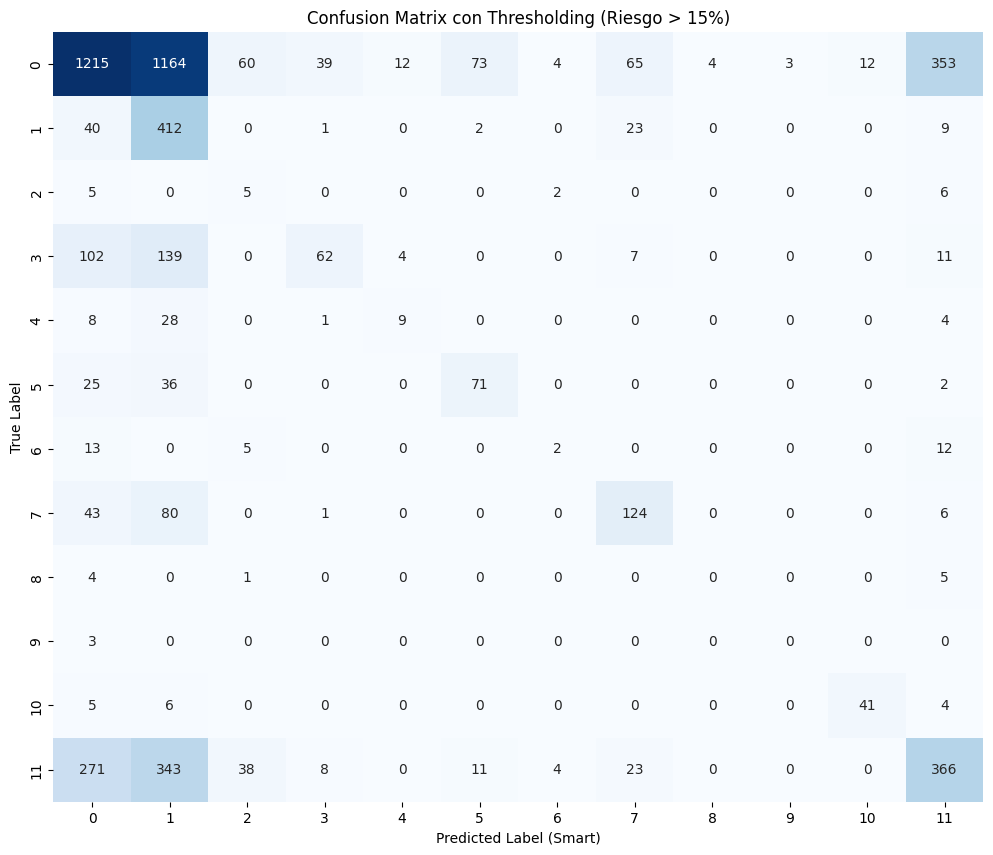

In [51]:
# Reporte Final
print("\n--- Reporte de Clasificación (Smart Predict) ---")
print(classification_report(y_true_all, y_pred_all))

print("\nMatriz de Confusión:")
cm = confusion_matrix(y_true_all, y_pred_all)
print(cm)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label (Smart)')
plt.ylabel('True Label')
plt.title('Confusion Matrix con Thresholding (Riesgo > 15%)')
plt.show()